# 고객 대출등급 예측: EDA

In [6]:
import numpy as np
import random
import os
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [7]:
import pandas as pd

# Load the dataset
file_path = 'data/train.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


- 대부분의 수치형 변수들은 0에서 시작하는 것으로 보입니다.
- 변수들은 서로 다른 스케일을 가지고 있으며, 일부 변수는 표준편차가 매우 큽니다 (예: 연간소득, 부채 대비 소득 비율).
- '총연체금액'과 '연체계좌수'의 최대 값은 상대적으로 낮은 편입니다.
- 대출기간, 근로기간, 주택소유상태, 대출목적, 대출등급과 같은 범주형 변수들은 인코딩이 필요합니다.

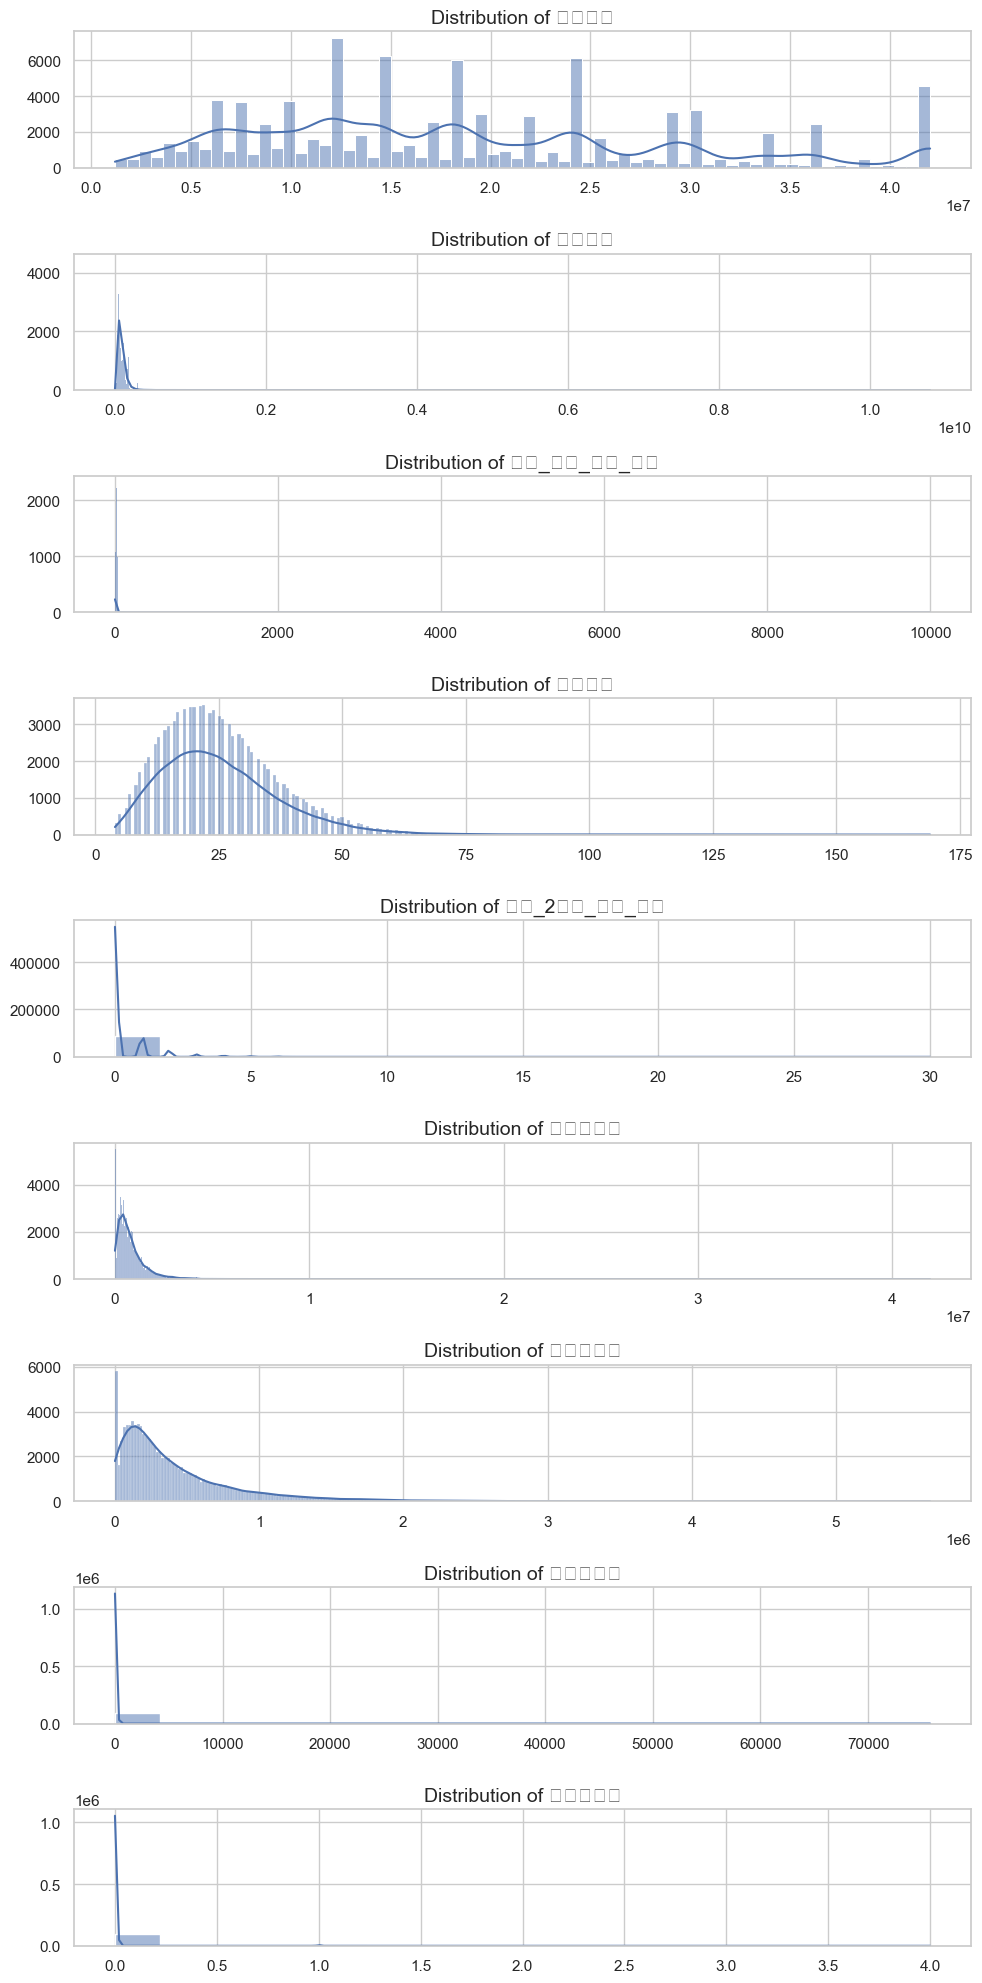

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

sns.set(style="whitegrid")

# List of numerical columns
numerical_columns = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# Plotting distributions of numerical columns
fig, axes = plt.subplots(len(numerical_columns), figsize=(10, 20))

for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

- 데이터에는 극단적인 값, 즉 아웃라이어(outliers)가 존재하는 것으로 보입니다. 이는 매우 좌측에 치우쳐 있는 분포에서 볼 수 있습니다.
- 대부분의 변수들은 긴 꼬리를 가진 분포를 보이며, 이는 특정 값 주변에 데이터가 집중되어 있고, 극소수의 매우 높거나 낮은 값들이 존재함을 의미합니다.
- 일부 그래프는 범위가 매우 넓고, 매우 큰 값들까지 포함하는 것을 보여주고 있습니다. 이는 변수의 스케일링이나 변환을 고려할 필요가 있음을 나타냅니다.

In [20]:
categorical_columns = data.select_dtypes(include=['object']).columns

# Calculating the frequency of each category in categorical columns
categorical_frequencies = {column: data[column].value_counts() for column in categorical_columns}

# Removing 'ID' from the analysis as it's a unique identifier
categorical_frequencies.pop('ID', None)

# For the relationship between loan grade (대출등급) and other variables,
# we'll create a function that calculates the mean of each numerical column grouped by the loan grade
def calculate_means_by_loan_grade(data, num_columns, group_by='대출등급'):
    means_by_loan_grade = {column: data.groupby(group_by)[column].mean() for column in num_columns}
    return means_by_loan_grade

# Identify numerical columns, excluding the 'ID' as it's just an identifier
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate the means of numerical columns grouped by the loan grade
means_by_loan_grade = calculate_means_by_loan_grade(data, numerical_columns)

categorical_frequencies, means_by_loan_grade

({'대출기간': 대출기간
   36 months    64479
   60 months    31815
  Name: count, dtype: int64,
  '근로기간': 근로기간
  10+ years    31585
  2 years       8450
  < 1 year      7774
  3 years       7581
  1 year        6249
  Unknown       5671
  5 years       5665
  4 years       5588
  8 years       4888
  6 years       3874
  7 years       3814
  9 years       3744
  10+years       896
  <1 year        370
  3               89
  1 years         56
  Name: count, dtype: int64,
  '주택소유상태': 주택소유상태
  MORTGAGE    47934
  RENT        37705
  OWN         10654
  ANY             1
  Name: count, dtype: int64,
  '대출목적': 대출목적
  부채 통합     55150
  신용 카드     24500
  주택 개선      6160
  기타         4725
  주요 구매      1803
  의료         1039
  자동차         797
  소규모 사업      787
  이사          506
  휴가          466
  주택          301
  재생 에너지       60
  Name: count, dtype: int64,
  '대출등급': 대출등급
  B    28817
  C    27623
  A    16772
  D    13354
  E     7354
  F     1954
  G      420
  Name: count, dtype: int64},
 {'대출금액'

범주형 변수의 빈도수:
- 대출기간: 대부분의 대출은 36개월(64,479건)이며, 60개월은 31,815건입니다.
- 근로기간: 가장 많은 범주는 '10+ years'(31,585건)이고, 그 다음으로는 '2 years'(8,450건), '< 1 year'(7,774건) 순입니다.
- 주택소유상태: 'MORTGAGE'(모기지)가 47,934건으로 가장 많고, 'RENT'(임대)는 37,705건, 'OWN'(소유)은 10,654건입니다.
- 대출목적: '부채 통합'이 55,150건으로 ㅡ가장 많고, '신용 카드'(24,500건), '주택 개선'(6,160건) 순입니다.
- 대출등급: 'B' 등급이 28,817건으로 가장 많고, 'C'(27,623건), 'A'(16,772건), 'D'(13,354건) 등의 순입니다.

대출등급과 다른 변수들 간의 관계(평균값):
- 대출금액: 'A' 등급이 평균 1.79억, 'G' 등급은 평균 2.40억으로, 등급이 낮아질수록 대출금액의 평균이 높아집니다.
- 연간소득: 'A' 등급의 평균 연간소득은 약 1.12억, 반면 'G' 등급은 약 0.83억으로, 등급이 높은 고객의 연간소득이 더 많습니다.
- 부채 대비 소득 비율: 'A' 등급은 평균 16.55%, 'G' 등급은 평균 20.69%로, 대출등급이 낮을수록 부채 대비 소득 비율이 높습니다.
- 총계좌수: 'A' 등급은 평균 약 27개, 'G' 등급은 약 25개의 계좌를 가지고 있습니다.
- 최근 2년간 연체 횟수: 'A' 등급은 평균 0.22회, 'G' 등급은 평균 0.42회로, 등급이 낮을수록 연체 횟수가 많습니다.
- 총상환원금: 'A' 등급의 평균 상환원금은 약 1,067만 원, 'G' 등급은 약 587만 원입니다.
- 총상환이자: 'A' 등급은 평균 약 224만 원, 'G' 등급은 약 1,285만 원으로, 대출등급이 낮을수록 상환 이자가 많습니다.
- 총연체금액: 'A' 등급은 평균 약 14,806원, 'G' 등급은 약 329,943원으로, 등급이 낮을수록 총연체금액이 많습니다.
- 연체계좌수: 'A' 등급은 평균 거의 0에 가까우며, 'G' 등급도 마찬가지로 매우 낮은 연체 계좌수를 가지고 있습니다.

1. 대출금액과 대출등급: 대출등급이 낮아질수록(즉, 위험이 높아질수록) 대출금액의 평균이 증가하는 경향을 보입니다. 이는 높은 위험을 감수하고 있는 고객들이 더 큰 금액을 빌리고 있음을 시사할 수 있습니다.

2. 연간소득과 대출등급: 높은 대출등급(A 등급)을 가진 고객들은 더 높은 연간소득을 가지고 있는 것으로 나타났습니다. 이는 대출을 제공하는 금융기관이 소득 수준이 높은 고객에게 더 좋은 대출등급을 부여할 가능성을 나타냅니다.

3. 부채 대비 소득 비율: 대출등급이 낮을수록(즉, 위험이 높을수록) 부채 대비 소득 비율이 높아지는 경향이 있습니다. 이는 더 낮은 대출등급의 고객들이 재정적으로 더 큰 부담을 지고 있을 수 있음을 의미합니다.

4. 총계좌수: 대출등급 간에 총계좌수는 큰 차이가 없으며, 모든 등급에서 비슷한 수의 계좌를 유지하고 있습니다. 이는 대출등급이 고객의 계좌 수와는 직접적인 상관관계가 없을 수 있음을 나타냅니다.

5. 최근 2년간 연체 횟수: 연체 횟수는 대출등급이 낮을수록 약간 증가하는 경향을 보입니다. 이는 낮은 대출등급의 고객이 과거에 대출 상환에 어려움을 겪었을 가능성을 시사합니다.

6. 총상환원금과 총상환이자: 상환원금과 상환이자 모두 대출등급이 낮을수록 감소하는 경향을 보입니다. 이는 대출등급이 낮은 고객들이 상대적으로 더 높은 이자율을 지불하고 있음을 나타낼 수 있습니다.

7. 총연체금액: 대출등급이 낮은 고객들이 평균적으로 더 높은 총연체금액을 가지고 있습니다. 이는 이들이 과거에 금융적으로 불안정했을 수 있음을 암시하며, 이러한 고객은 잠재적인 리스크가 높다고 볼 수 있습니다.